# Import Packages

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
import os
from matplotlib import pyplot as plt
from sklearn import linear_model

In [3]:
pwd

'C:\\Users\\dszigeti\\Desktop\\py_workspace\\20190705\\20190705_Load_Forecasting'

# Import Data

In [7]:
# location of data
file = '../data/tacoma.csv'

data = pd.read_csv(file)
data = pd.melt(data, id_vars=['date', 'high', 'low', 'tdelta'])
data.columns = ['date', 'high', 'low', 'tdelta', 'time', 'load']
data['date'] = data['date'].astype(str) + ' ' + data['time'].astype(str)
data = data.drop('time', axis=1)


data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.sort_values(by='date', inplace = True)

data['date']
data.set_index('date', inplace=True)

# time of day
data['hour'] = data.index.hour

# isoweek number
data['dates'] = data.index.date
data['iso_week'] = data.dates.apply(lambda x: x.isocalendar()[1])
data.drop('dates', axis=1, inplace=True)

# 0 = monday, 6 = sunday
data['dayofweek'] = data.index.dayofweek
#dropna
data.dropna(inplace=True)
data['temp_avg'] = data[['high', 'low']].mean(axis=1)

## Add daytype, dayofyear, logload

In [ ]:
# set values for daytype
conditions = [
    # non workday
    (data['dayofweek'].astype(float) == 5),
    (data['dayofweek'].astype(float) == 6),
    
    # day before non workday
    (data['dayofweek'].astype(float) == (4)),
    
    # day after non workday
    (data['dayofweek'].astype(float) == (0))]

choices = [0, 0, 1, 2]
data['day_type'] = np.select(conditions, choices, default='-1')

# add columns for dayofyear and logload
data['dayofyear'] = data.index.dayofyear
data['logload'] = np.log(data.load)

In [ ]:
# write data to file
data.to_csv('pydata.csv', index='date', header=True)

# train/test split
* in the future, this will become a function/loop that will do kfold cross validation

In [13]:
# split train and test data
# only iso week 53 is 2016
train = data['2013':'2017']

#, data['2014-01'], data['2015-01'], data['2016-01'],data['2017-01']
test = data['2018']
train_load = train.load.to_frame()
test_load = test.load.to_frame()

In [14]:
data.head()

,high,low,tdelta,load,hour,iso_week,dayofweek,temp_avg
date,,,,,,,,
2006-01-01 00:00:00,57.0,44.0,13.0,530.0,0,52,6,50.5
2006-01-01 01:00:00,57.0,44.0,13.0,519.0,1,52,6,50.5
2006-01-01 02:00:00,57.0,44.0,13.0,502.0,2,52,6,50.5
2006-01-01 03:00:00,57.0,44.0,13.0,492.0,3,52,6,50.5
2006-01-01 04:00:00,57.0,44.0,13.0,488.0,4,52,6,50.5



# Make Samples data prep
* max load past 24 hrs
* min load past 24 hrs
* avg load past 7 days
* high temp past 24 hrs
* low temp past 24 hrs
* avg temp (??) past 7 days
    * is it sufficient to just do high/low average from past days?
* day of week
* holiday effect
* day of year
​
​
## to do later
* load for same time past two days (delta?)

In [15]:
# rn this doesn't do anything
def make_samples(df, freq, periods, fun):
    
    # index of first time:
    start_time = df.index.min()
    
    sample_idx = pd.date_range(start=start_time, freq=freq, periods=periods)
    output_idx = pd.date_range(start=sample_idx.max(), end=df.index.max(),
                              freq=freq)
    output = pd.DataFrame(columns=['load'], index=output_idx)
    
    
    output = output.apply(lambda x: x, axis=1)
    return

In [16]:
# samples: list of data and associated index
def get_value(d, s, fun):
    value = 0
    
    if (fun == 'max'):
        value = d.loc[s].max()
        
    elif (fun == 'min'):
        value = d.loc[s].min()

    elif (fun == 'avg'):
        value = d.loc[s].mean()
    else:
        value = 99999999999999999
        
    return value

# takes as input parameters, spits out a dataframe with the requested data
def make_samples(df, freq, periods, fun):
    
    # first sample's index
    start_time = df.index.min()
    
    sample_idx = pd.date_range(start=start_time, freq=freq, periods=periods)
    output_idx = pd.date_range(start=sample_idx.max(), end=df.index.max(), freq=freq)
    output = pd.DataFrame(columns=['load'], index=output_idx)
                          
    for i in output_idx:
    
        # try to find samples in original df, if not, skip?
        try:
            output.loc[i] = get_value(df, sample_idx, fun)
            
        # if any of the sample_idx do not exist in df, skip and calculate next
        # this leaves the value as NaN in output
        except:
            pass
        
        # iterate time delta by one freq unit                  
        start_time = start_time + pd.Timedelta(1, freq)
        
        #update sample_idx
        sample_idx = pd.date_range(start=start_time, freq=freq, periods=periods)
    
    return output


## Temperature effects

C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternativ

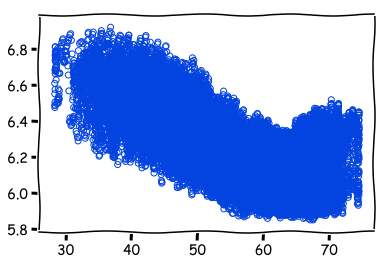

In [17]:
# max temp in 24 hours

train_temp_high = make_samples(train.high, 'H', 24, 'max')
train_temp_low = make_samples(train.low, 'H', 24, 'min')
train_temp_avg = make_samples(train.temp_avg, 'H', 168, 'avg')
with plt.xkcd():
#    plt.scatter(train_temp_high, np.log(train.load[train_temp_high.index]), facecolor='None', edgecolor='xkcd:purple')
 #   plt.scatter(train_temp_low, np.log(train.load[train_temp_low.index]), facecolor='None', edgecolor='xkcd:pink')
    plt.scatter(train_temp_avg, np.log(train.load[train_temp_avg.index]), facecolor='None', edgecolor='xkcd:blue')
    
    

In [18]:
test_temp_high = make_samples(test.high, 'H', 24, 'max')
test_temp_low = make_samples(test.low, 'H', 24, 'min')
test_temp_avg = make_samples(test.temp_avg, 'H', 168, 'avg')

## Calendar Effects
* day of week
* type of day
* new year's eve
* christmas
* smooth function (estimated with cubic regression spline)

In [19]:
train_load_max = make_samples(train.load, 'H', 24, 'max')
train_load_min = make_samples(train.load, 'H', 24, 'min')
train_load_avg = make_samples(train.load, 'H', 24, 'avg')



C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternativ

C:\Users\dszigeti\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


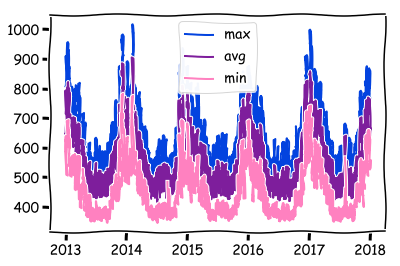

In [20]:
with plt.xkcd():
#    plt.scatter(train_temp_high, np.log(train.load[train_temp_high.index]), facecolor='None', edgecolor='xkcd:purple')
 #   plt.scatter(train_temp_low, np.log(train.load[train_temp_low.index]), facecolor='None', edgecolor='xkcd:pink')
    plt.plot(train_load_max.index, train_load_max, color='xkcd:blue')
    plt.plot(train_load_avg.index, train_load_avg, color='xkcd:purple')
    plt.plot(train_load_min.index, train_load_min, color='xkcd:pink')
    plt.legend(['max', 'avg', 'min'])

In [21]:
test_load_max = make_samples(test.load, 'H', 24, 'max')
test_load_min = make_samples(test.load, 'H', 24, 'min')
test_load_avg = make_samples(test.load, 'H', 24, 'avg')

# Make Splines

In [22]:
# Downsample training data

# data: data
# name of data column
# bucket = Day, month?
def prep_data(data, name, bucket):
    
    # down sample data
    data_new = data.resample('%s' %(bucket)).mean()
    data_new.columns = ['%s' %(name)]
    
    # make time buckets for new index
    data_new['date_delta'] = (data_new.index - data_new.index.min())/ np.timedelta64(1, '%s' %(bucket))
    
    X_train = data_new['date_delta']
    y_train = data_new['%s' %(name)]
    
    # set up cubic spline
    from scipy.interpolate import UnivariateSpline
    spline = UnivariateSpline(X_train, y_train, k=3, s=5)
    
    return spline

# downsample test data and predict with spline
def predict_spline(data, name, bucket, spline):
    # downsample
    from scipy import interpolate
    data_new = data.resample('%s' %(bucket)).mean().to_frame()
    data_new.columns = ['%s' %(name)]
    
    
    data_new['date_delta'] = (data_new.index - data_new.index.min()) / np.timedelta64(1, '%s' %(bucket))
    data_new.columns = ['%s' %(name), 'date_delta']
    X_test = data_new['date_delta']
    y_test = data_new['%s' %(name)]
    prediction = spline(X_test)

    return y_test, prediction

In [213]:
# set index of train_processed to same as train
train_processed = pd.DataFrame(index=train.index)

train_processed['tdelta'] = train.tdelta
train_processed['high'] = train_temp_high
train_processed['avg'] = train_temp_avg
train_processed['low'] = train_temp_low
train_processed['load_max'] = train_load_max
train_processed['load_avg'] = train_load_avg
train_processed['load_min'] = train_load_min
train_processed['iso_week'] = train.iso_week
train_processed['dayofweek'] = train.dayofweek
train_processed['hour'] = train.hour
train_processed['load_true'] = train.load

In [214]:
train_processed['high_true'] = train.high
train_processed['low_true'] = train.low

In [215]:
# set values for daytype
conditions = [
    # non workday
    (train_processed['dayofweek'].astype(float) == 5),
    (train_processed['dayofweek'].astype(float) == 6),
    
    # day before non workday
    (train_processed['dayofweek'].astype(float) == (4)),
    
    # day after non workday
    (train_processed['dayofweek'].astype(float) == (0))]

choices = [0, 0, 1, 2]
train_processed['day_type'] = np.select(conditions, choices, default='-1')

In [216]:
#fill na
train_processed.bfill(inplace=True)

In [217]:
#! rewrite this if it's faster to find intersection than to loc
# make dataset for weeks
def make_dataset(data, week_id, day_id, hour_id):
  
    if week_id == 1:
        last_week = data.loc[(data.iso_week == 52)
                     & (data.dayofweek == day_id)
                     & (data.hour == hour_id)]
    else:
        last_week = data.loc[(data.iso_week == week_id - 1)
                     & (data.dayofweek == day_id)
                     & (data.hour == hour_id)]

    this_week = data.loc[(data.iso_week == week_id)
                     & (data.dayofweek == day_id)
                     & (data.hour == hour_id)]
    
    
    next_week = data.loc[(data.iso_week == week_id + 1)
                     & (data.dayofweek == day_id)
                     & (data.hour == hour_id)]
    
    week = [last_week, this_week, next_week]
    week = pd.concat(week)
    return week

# take training data and find a line
# returns intercept and coefficient
def fit_model(X_train, y_train):
    model = linear_model.LinearRegression()
    results = model.fit(X_train, y_train)
    intercept, coef = results.intercept_, results.coef_
    return intercept, coef

int_list = list()
coef_list = list()
idx_list = list()

for wk in range(1, 53, +1):
  for day in range(0, 7, +1):
    for hour in range(0, 24, +1):
        train_subset = make_dataset(train_processed, wk, day, hour).dropna()
        # get the subset of data to be tested for model
        
        # split x/y data
        y_train, X_train = train_subset.load_true, train_subset.drop(['load_true'], axis=1)

        
        intercept, coef = fit_model(X_train, y_train)
        idx = [wk, day, hour]
        idx_list.append(idx)
        int_list.append(intercept)
        coef_list.append(coef)

In [229]:
# process test data for testing
# set index of train_processed to same as train
test_processed = pd.DataFrame(index=test.index)

test_processed['tdelta'] = test.tdelta
test_processed['high'] = test_temp_high
test_processed['avg'] = test_temp_avg
test_processed['low'] = test_temp_low
test_processed['load_max'] = test_load_max
test_processed['load_avg'] = test_load_avg
test_processed['load_min'] = test_load_min
test_processed['iso_week'] = test.iso_week
test_processed['dayofweek'] = test.dayofweek
test_processed['hour'] = test.hour
test_processed['load_true'] = test.load
test_processed['high_true'] = test.high
test_processed['low_true'] = test.low

conditions = [
    # non workday
    (test_processed['dayofweek'].astype(float) == 5),
    (test_processed['dayofweek'].astype(float) == 6),
    
    # day before non workday
    (test_processed['dayofweek'].astype(float) == (4)),
    
    # day after non workday
    (test_processed['dayofweek'].astype(float) == (0))]


test_processed['day_type'] = np.select(conditions, choices, default='-1')

#fill na
test_processed.bfill(inplace=True)

In [230]:
y_test, X_test = test_processed.load_true, test_processed.drop(['load_true'], axis=1)

# Fit model! ヽ(o＾▽＾o)ノ

In [231]:
# turn output into dataframes and combine
intercept = pd.DataFrame({'intercept':int_list})
coefficients = pd.DataFrame(coef_list, columns=['xtdelta', 
                                               'xhigh',
                                               'xavg',
                                               'xlow',
                                               'xload_max',
                                               'xload_avg',
                                               'xload_min',
                                               'xiso_week',
                                               'xdayofweek',
                                               'xhour',
                                               'xday_type',
                                               'xhigh_true',
                                               'xlow_true'])

In [232]:
idx = pd.DataFrame(idx_list, columns=['iso_week', 'dayofweek', 'hour'])
final_model = pd.DataFrame.join(intercept, coefficients, how='outer')
final_model = pd.DataFrame.join(idx, final_model, how='outer')

In [233]:
final_model.drop(['xdayofweek', 'xhour','xday_type'], axis=1)

,iso_week,dayofweek,hour,intercept,xtdelta,xhigh,xavg,xlow,xload_max,xload_avg,xload_min,xiso_week,xhigh_true,xlow_true
0,1,0,0,352.973785,-3.133007,3.700819,-0.413565,9.160775,0.987246,-0.178789,-0.338513,0.272832,-5.875641,0.0
1,1,0,1,782.312355,-1.848555,1.705364,-2.542826,-3.798094,1.367384,-2.229637,1.091541,0.175791,-1.354489,0.0
2,1,0,2,626.543068,-2.034084,2.900662,-2.987160,-3.218940,0.930489,-1.723849,1.226065,0.110424,-1.129567,0.0
3,1,0,3,862.955101,-2.135702,3.917925,-4.556331,-3.790607,0.915908,-1.882285,1.208331,0.099675,-1.963297,0.0
4,1,0,4,338.673049,-1.207977,3.400453,-2.379618,-1.264679,0.578681,-1.086072,1.237586,-0.039821,-1.491431,0.0
5,1,0,5,88.816526,0.924442,5.531531,-0.774112,1.281741,-0.438906,0.826943,0.546225,-0.246502,-3.974354,0.0
6,1,0,6,-35.585796,3.798797,5.106837,1.719067,3.756553,-0.942224,2.058974,-0.166338,-0.656566,-6.126580,0.0
7,1,0,7,149.592393,5.232694,2.233988,1.861407,4.757247,0.770107,0.291129,-0.434363,-0.685706,-7.072666,0.0
8,1,0,8,-102.511260,4.359038,3.348253,2.305043,5.326968,0.541332,0.859457,-0.479560,-0.653093,-6.397972,0.0
9,1,0,9,403.488142,3.718407,3.638146,1.252418,3.527273,0.144284,1.106292,-0.740229,-0.393407,-7.551162,0.0


In [239]:
X_input = X_test
X_input

,tdelta,high,avg,low,load_max,load_avg,load_min,iso_week,dayofweek,hour,high_true,low_true,day_type
date,,,,,,,,,,,,,
2018-01-01 00:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,0,43.0,31.0,2
2018-01-01 01:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,1,43.0,31.0,2
2018-01-01 02:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,2,43.0,31.0,2
2018-01-01 03:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,3,43.0,31.0,2
2018-01-01 04:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,4,43.0,31.0,2
2018-01-01 05:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,5,43.0,31.0,2
2018-01-01 06:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,6,43.0,31.0,2
2018-01-01 07:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,7,43.0,31.0,2
2018-01-01 08:00:00,12.0,43.0,41.571429,31.0,790.0,699.791667,609.0,1,0,8,43.0,31.0,2


In [240]:
coef = pd.DataFrame.merge(final_model, X_input, on=['iso_week', 'hour', 'dayofweek'], how='outer').drop(['xdayofweek', 'xhour'], axis=1)

# make prediction!
prediction = (X_input.tdelta.values * coef.xtdelta.values
        + X_input.high.values * coef.xhigh.values
        + X_input.avg.values * coef.xavg.values
        + X_input.low.values * coef.xlow.values 
        + X_input.load_max.values * coef.xload_max.values
        + X_input.load_avg.values * coef.xload_avg.values
        + X_input.load_min.values * coef.xload_min.values
        + X_input.high_true.values * coef.xhigh_true.values
        + X_input.low_true.values * coef.xlow_true.values
        + coef.intercept.values)

In [241]:
prediction

array([ 937.30688746,  937.30688746,  736.4679339 , ..., -150.99340527,
         16.58486138,  686.56437679])

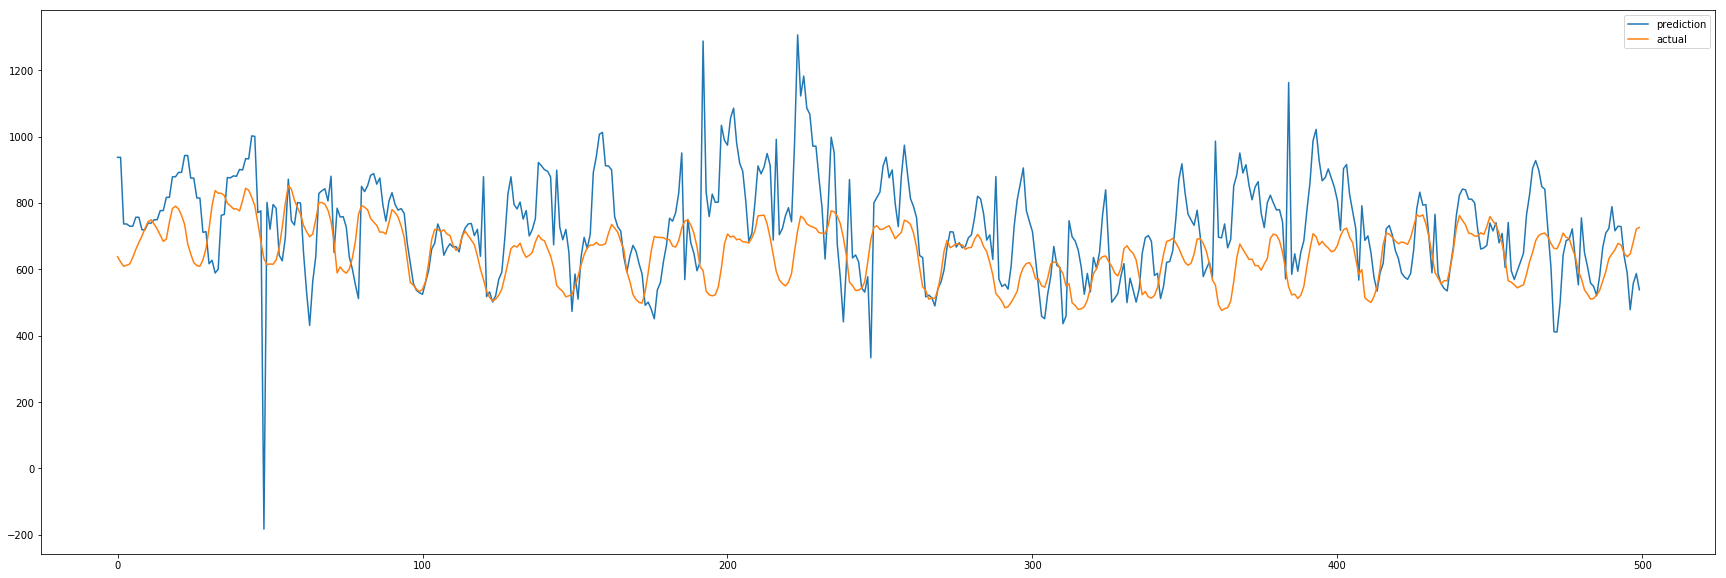

In [245]:
from matplotlib import pyplot as plt
from pylab import rcParams
from matplotlib import figure

rcParams['figure.figsize'] = 30, 10
# rotate and align the tick labels so they look better

start = 0
end = 500


plt.plot(prediction[start:end])
plt.plot(y_test[start:end].values)

plt.legend(['prediction', 'actual'])

In [246]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
RMSE = sqrt(mean_squared_error(y_test[start:end], prediction[start:end]))
MAPE = mean_absolute_percentage_error(y_test[start:end], prediction[start:end])

print('RMSE: [{}]'.format(RMSE))
print('MAPE: [{}]'.format(MAPE))

RMSE: [158.08144132600907]
MAPE: [18.62672936093689]
